<a href="https://colab.research.google.com/github/mostafa-ja/Transformers/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
[kaggle tutorial link](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook)



#  Import Libraries




In [25]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

1.13.1+cu116


# Basic components

Create Word Embeddings

First of all we need to convert each word in the input sequence to an embedding vector. Embedding vectors will create a more semantic representation of each word.

Suppoese each embedding vector is of 512 dimension and suppose our vocab size is 100, then our embedding matrix will be of size 100x512. These marix will be learned on training and during inference each word will be mapped to corresponding 512 d vector. Suppose we have batch size of 32 and sequence length of 10(10 words). The the output will be 32x10x512.

In [26]:
class Embedding(nn.Module):
  def __init__(self,vocab_size,embed_dim):
    super(Embedding,self).__init__()
    self.embed = nn.Embedding(vocab_size,embed_dim)

  def forward(self,x):
    out = self.embed(x)
    return out

# Positional Encoding

Positinal embedding will generate a matrix of similar to embedding matrix. It will create a matrix of dimension sequence length x embedding dimension. For each token(word) in sequence, we will find the embedding vector which is of dimension 1 x 512 and it is added with the correspondng positional vector which is of dimension 1 x 512 to get 1 x 512 dim out for each word/token.

for eg: if we have batch size of 32 and seq length of 10 and let embedding dimension be 512. Then we will have embedding vector of dimension 32 x 10 x 512. Similarly we will have positional encoding vector of dimension 32 x 10 x 512. Then we add both

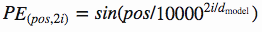

In [27]:
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.


class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_dim):
        super().__init__()
        self.embed_dim = embed_dim 
        assert embed_dim % 2 == 0 ,'embed_dim must be even'
        pe = torch.zeros(max_seq_len,embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed_dim))) #i have doubt about (i+1) or (i)
        pe = pe.unsqueeze(0) #shape:(1,max_seq_len,embed_dim)
        self.register_buffer('pe', pe)


    def forward(self, x):      
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len] #shape:(1,seq_len,embed_dim)
        return x

# Self Attention

**Step 1**: The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. Each of the vector will be of dimension 1x64.

Suppose we have batch_size=32,sequence_length=10, embedding dimension=512. So after embedding and positional encoding our output will be of dimension 32x10x512.
We will resize it to 32x10x8x64.(About 8, it is the number of heads in multihead attention.Dont worry you will get to know about it once you go through the code.).

**Step 2**: Second step is to calculate the score. ie, we will multiply query marix with key matrix. [Q x K.t]

Suppose our key,query and value dimension be 32x10x8x64. Before proceeding further, we will transpose each of them for multiplication convinience (32x8x10x64). Now multiply query matrix with transpose key matrix. ie (32x8x10x64) x (32x8x64x10) -> (32x8x10x10).

**Step 3:** Now divide the output matrix with square root of dimension of key matrix and then apply Softmax over it.

we will divide 32x8x10x10 vector by 8 ie, by square root of 64 (dimension of key matrix)

**Step 4:** Then this gets multiply it with value matrix.

After step 3 our output will be of dimension 32x8x10x10. Now muliply it with value matrix (32x8x10x64) to get output of dimension (32x8x10x64).Here 8 is the number of attention heads and 10 is the sequence length.Thus for each word we have 64 dim vector.

**Step 5**: Once we have this we will pass this through a linear layer. This forms the output of multihead attention.

(32x8x10x64) vector gets transposed to (32x10x8x64) and then reshaped as (32x10x512).Then it is passed through a linear layer to get output of (32x10x512).

A ‘View’ uses the same chunk of memory block as the original tensor, and thus any changes among this memory chunk will affect all the views and the original tensor that’s associated with it.  

Transpose( ) has Non-Contiguous Data Structure

A non-contiguous tensor view can be converted to a contiguous one, and it would make a copy of it, so the data will not be associated with the original data chunk anymore.

Difference between view() and reshape():

**view() cannot apply on ‘non-contiguous’ tensor** for example after using transpose we cannot use view unless we make it contigous(define new arrange of elemnts in matrice which is diffrent from the first diffinition like the below pic).

reshape() can apply on both ‘contiguous’ and ‘non-contiguous’ tensor/view. When possible, it will return a view; When the data is non-contiguous, it makes a new copy of it.

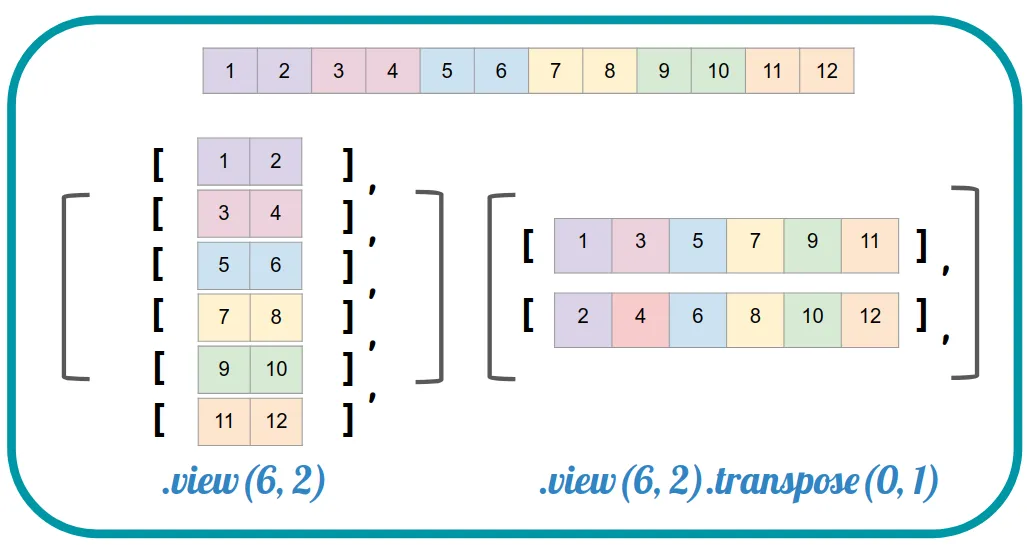

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d
       
        #key,query and value matrixes    #64 x 64   
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
        
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        
        # query dimension can change in decoder during inference. 
        # so we cant take general seq_length
        seq_length_query = query.size(1)
        
        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
       
        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)   
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
       
        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
      
        
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)
 
        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64) 
        
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        #after transpose , the tensor will be not contiguous, so we cannot use view() after that unless we first make it contaguous then use view
        #contaguous means that for example we have a tensor:[1,2,...,10] with changing shape into (2,5) the order does not change but if we use transpose ,
        #the main order will get mixed up(check the top pic) so we need to define again the order by  contiguous()
        
        output = self.out(concat) #(32,10,512) -> (32,10,512)
       
        return output


# Encoder

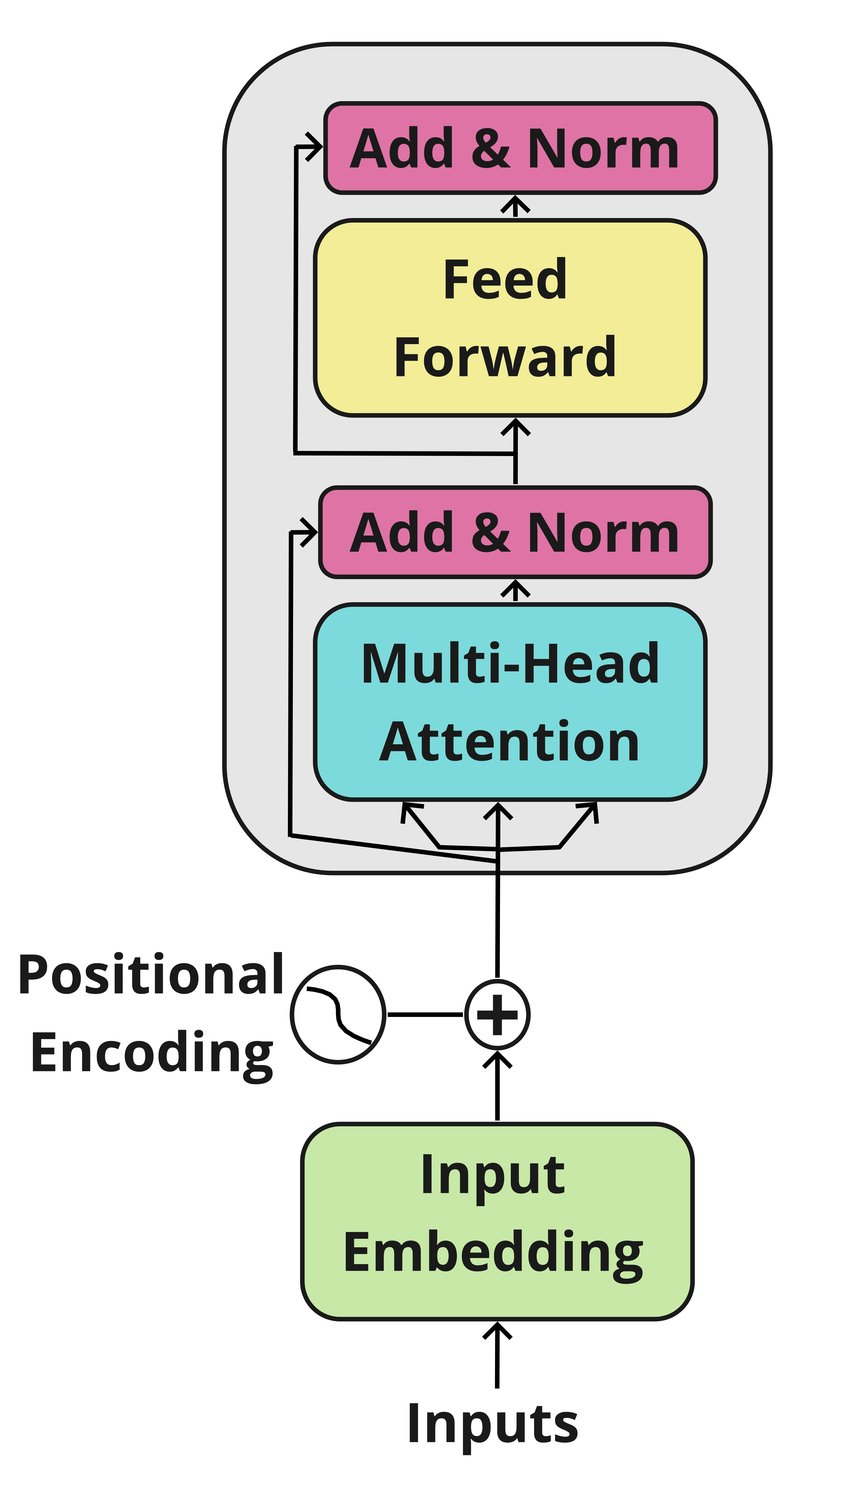

**Step 1**: First input get passes through embedding layer and positional encoding layer.

suppose we have input of 32x10 (batch size=32 and sequence length=10). Once it passes through embedding layer it becomes 32x10x512. Then it gets added with correspondng positional encoding vector and produces output of 32x10x512. This gets passed to the multihead attention

**Step 2:** As discussed above it will passed through the multihead attention layer and creates useful representational matrix as output.

input to multihead attention will be a 32x10x512 from which key,query and value vectors are generated as above and finally produces a 32x10x512 output.

**Step 3**: Next we have a normalization and residual connection. The output from multihead attention is added with its input and then normalized.

output of multihead attention which is 32x10x512 gets added with 32x10x512 input(which is output created by embedding vector) and then the layer is normalized.

**Step 4**: Next we have a feed forward layer and a then normalization layer 
with residual connection from input(input of feed forward layer) where we passes the output after normalization though it and finally gets the output of encoder.

The normalized output will be of dimension 32x10x512. This gets passed through 2 linear layers: 32x10x512 -> 32x10x2048 -> 32x10x512. Finally we have a residual connection which gets added with the output and the layer is normalized. Thus a 32x10x512 dimensional vector is created as output for the encoder.

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim) 
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):
                
        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out

In [30]:
class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention
        
    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

The difference between 


```
self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
```

```
self.layers = [TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)]
```

 is that the former uses nn.ModuleList to create a list of sub-modules, while the latter creates a list of plain Python objects.

When using nn.ModuleList, the sub-modules are automatically registered with the parent module, so that they can be tracked and managed by PyTorch. For example, when calling model.parameters(), PyTorch will automatically collect the parameters of all sub-modules that have been registered with the parent module.

On the other hand, when using a plain Python list, the sub-modules are not automatically registered with the parent module. This means that PyTorch will not be aware of the sub-modules, and the parameters of the sub-modules will not be included in model.parameters(). Additionally, when moving the model to a different device using model.to(), the sub-modules will not be moved automatically.

Therefore, it is generally recommended to use nn.ModuleList when creating a list of sub-modules in a PyTorch module.

# Decoder

We will use the output of encoder to generate key and value vectors for the decoder.There are two kinds of multi head attention in the decoder.One is the decoder attention and other is the encoder decoder attention. 

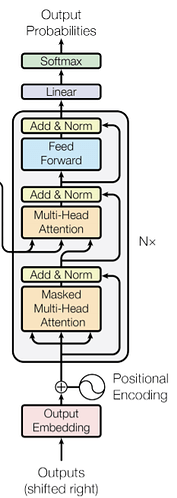

**Step 1:**

First the output gets passed through the embeddin and positional encoding to create a embedding vector of dimension 1x512 corresponding to each word in the target sequence.

Suppose we have a sequence length of 10. batch size of 32 and embedding vector dimension of 512. we have input of size 32x10 to the embedding matrix which produces and output of dimension 32x10x512 which gets added with the positional encoding of same dimension and produces a 32x10x512 out

**Step 2:**

The embeddig output gets passed through a multihead attention layers as before(creating key,query and value matrixes from the target input) and produces an output vector. This time the major difference is that we uses a mask with multihead attention.

Why mask?

Mask is used because while creating attention of target words, we donot need a word to look in to the future words to check the dependency. ie, we already learned that why we create attention because we need to know contribution of each word with the other word. Since we are creating attention for words in target sequnce, we donot need a particular word to see the future words. For eg: in word "I am a strudent", we donot need the word "a" to look word "student".

For creating attention we created a triangular matrix with 1 and 0.eg:traingular matrix for seq length 5 looks as below:



```
1 0 0 0 0
1 1 0 0 0
1 1 1 0 0
1 1 1 1 0
1 1 1 1 1
```


After the key gets multiplied with query, we fill all zero positions with negative inifinity, In code we will fill it with a very small number to avoid division errors.
(with -1e 20)

**Step 3:**

As before we have a add and norm layer where we add with output of embedding with attention out and normalized it.

**Step 4:**

Next we have another multihead attention and then a add and norm layer. This multihead attention is called encoder-decorder multihead attention. For this multihead attention we create we create key and value vectors from the encoder output. Query is created from the output of previous decoder layer.


Thus we have 32x10x512 out from encoder out. key and value for all words are generated from it. Similary query matrix is generated from otput from previous layer of decoder(32x10x512).
Thus it is passed through a multihead atention (we used number of heads = 8) the through a Add and Norm layer. Here the output from previous encoder layer(ie previoud add and norm layer) gets added with encoder-decoder attention output and then normalized.

**Step 5:** Next we have a feed forward layer(linear layer) with add and nom which is similar to that of present in the encoder.

**Step 6:** Finally we create a linear layer with length equal to number of words in total target corpus and a softmax function with it to get probablity of each word.

In [31]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)
        
    
    def forward(self, key, query, x,mask):
        
        """
        Args:
            x: inputs from decoder, after positional embeding
           key: key vector from encoder
           query: query vector from encoder
           value: value vector from first attention block
           mask: mask to be given for multi head attention 
        Returns:
           out: output of transformer block
    
        """
        
        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))
        
        out = self.transformer_block(key, query, value)

        
        return out

In [32]:
class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask): 
        
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """
            
        
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)
     
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask) # attention: should be (enc_out, enc_out, x, mask) not (enc_out, x, enc_out, mask) !!?

        out = F.softmax(self.fc_out(x))

        return out

Finally we will arrange all submodules and creates the entire tranformer architecture.

In [33]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim:  dimension of embedding 
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        
        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask    

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)
          
        
        return out_labels
    
    def forward(self, src, trg):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
   
        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

In [34]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
model

torch.Size([2, 12]) torch.Size([2, 12])


Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropou

In [35]:

out = model(src, target)
out.shape

torch.Size([2, 12, 11])

In [36]:
# inference
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length, 
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
                  


src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])
trg = torch.tensor([[0]])
print(src.shape,trg.shape)
out = model.decode(src, trg)
out

torch.Size([1, 12]) torch.Size([1, 1])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]